# Modifying code from jgarci92 to aggregate classifications and eliminate outliers


Our goal here is to take the original python code and make it so that we can eliminate the bad classifications from Zooniverse users and only pass on good classification data to the machine learning algorithm.

## First import a bunch of modules to use:

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as col
from sklearn.cluster import DBSCAN
from sklearn import metrics
from matplotlib.patches import Ellipse
style.use('ggplot')

from itertools import filterfalse

import csv

from astropy.stats import circmean
from astropy import units as u

import matplotlib.cm as cm
import matplotlib.colors as col
cmap_1 = cm.ScalarMappable(col.Normalize(1, 11, cm.gist_rainbow))

## Open file and store in data:

In [4]:
# new-steelpan-vibrations-classifications.csv should be generated from csvcount routine
with open("steelpan-vibrations-classifications-five_or_more-071020.csv") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    data = [r for r in reader]

## This is the main data parsing routine:

In [5]:
allsubjectids = []
for i in range(len(data)):
    allsubjectids.append(int(data[i][13]))

#Remove duplicate subject_ids
uniquesubjectids = (set(allsubjectids))

# Initialize empty dictionary of our subjects to be checked
d = {}
# Fill dictionary with keys from uniquesubjectids
for k in uniquesubjectids:
    d['coords'+str(k)] = []


# Parse the raw classification data for the subjects to be checked    
for i in range(len(data)):
    parsed_json = json.loads(data[i][11])
    if data[i][5] != "Retirement Limit Test" and int(data[i][13]) in uniquesubjectids:
        if len(parsed_json)==2:
            for j in range(len(parsed_json[1]['value'])):
                if len(parsed_json[1]['value'][j]['details']) == 1:
                    if isinstance(parsed_json[1]['value'][j]['details'][0]['value'], str):
                        try:
                            fringe_count = int(parsed_json[1]['value'][j]['details'][0]['value'])
                        except ValueError:
                            pass

                    else:
                        fringe_count = parsed_json[1]['value'][j]['details'][0]['value']
                    
                    datalist = [parsed_json[1]['value'][j]['x'],parsed_json[1]['value'][j]['y'],data[i][13],fringe_count,parsed_json[1]['value'][j]['rx'],parsed_json[1]['value'][j]['ry'],parsed_json[1]['value'][j]['angle']]
                    
                    d['coords'+data[i][13]].append(datalist)
                    
        elif len(parsed_json)==1:
            # If there are no fringes recorded, fill every field except subject_id with 0 -> parse later
            datalist = [0,0,data[i][13],0,0,0,0]
            d['coords'+data[i][13]].append(datalist)
            #print(data[i][13]," No antinodes found!")
            
print(len(data))

41310


## Important functions

The functions dbscan, draw_ellipse, and df_to_center_plt were initially written by jgarci92 and are used for generating the plots for each subject.

The function dbscan_average is needed to generate the average classifications for seeding the machine learning algorithm.

In [6]:
def dbscan(crds):
    bad_xy = []  #might need to change this
    X = np.array(crds)
    db = DBSCAN(eps=18, min_samples=3).fit(X)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = set(labels)
    
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = 'k'

        class_member_mask = (labels == k)
        
        # These are the definitely "good" xy values.
        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)
        #print("\n Good? xy = ",xy)
        #print("X = ",X)
        # These are the "bad" xy values. Note that some maybe-bad and maybe-good are included here.
        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=6)
        #print("\n Bad? xy = ",xy)
        bad_xy.append(xy)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.xlim(0, 512)
    plt.ylim(0, 384)
    
    return bad_xy

In [7]:
def draw_ellipse(ell):
    fig = plt.figure(0)
    ax = fig.add_subplot(111, aspect='equal')
    for e in ell:
        ax.add_artist(e)
        e.set_alpha(.3)
    ax.set_xlim(0, 512)
    ax.set_ylim(0, 384)
    plt.show()

In [8]:
def df_to_center_plt(coords_x):
    x_val = []
    y_val = []
    frng = []
    crds = []
    ell = []
    
    for centers in coords_x:
        # The IndexErrors *might* have been fixed, but this has not been checked yet.
        try:
            x_val.append(centers[0])
        except IndexError:
            pass
        try:
            y_val.append(centers[1])
        except IndexError:
            pass
        try:
            frng.append(centers[3])
        except IndexError:
            pass
        try:
            crds.append([centers[0], centers[1]])
        except IndexError:
            pass
        try:
            ell.append(Ellipse(xy=[centers[0], centers[1]], width=centers[4], height=centers[5], angle=centers[6]))
        except IndexError:
            pass
    centers_raw = {'XVal': x_val,
                   'YVal': y_val,
                   'Fringe': frng}
    
    centers_df = pd.DataFrame(centers_raw, columns=['XVal', 'YVal', 'Fringe'])
    plt.scatter(centers_df.XVal, centers_df.YVal, s=20, c=cmap_1.to_rgba(centers_df.Fringe), alpha=.6)
    plt.xlim(0, 512)
    plt.ylim(0, 384)
    plt.title('Subject id = %s'%(coords_x[0][2]))
    plt.show()
    bad_xy = dbscan(crds)
    #print("bad_xy = ",bad_xy)
    #for each in ell:
    #    print("ell.center = ",each.center)
    #    print("ell.angle = ",each.angle)
    #    print("ell.width = ",each.width)
    #    print("ell.height = ",each.height)
    draw_ellipse(ell)
    
    ###Filter out the bad_xy entries - we will only look at bad x coordinates and remove all entries matching the bad_x.
    ###There is probably a better way to do this, or at least do more cross checking.
    bad_x = 0
    new_coords_x = []
    keepgood = coords_x
    for i in range(len(bad_xy)):
        try:
            for j in range(len(bad_xy[i])):
                try:
                    
                    bad_x = bad_xy[i][j][0]
                    # bad_y is not (currently) being used.
                    bad_y = bad_xy[i][j][1]
                    #print("bad_x = ",bad_x)
                    # This list comprehension step is what removes the bad ellipse
                    keepgood = [item for item in keepgood if item[:][0] != bad_x]
                    
                except IndexError:
                    pass
                #if bad_x != coords_x[i][0]:
                #        print(coords_x[i])
            #if bad_x == coords_x[i][0]:
            #    print("Bad Entry!")
            #else:
            #    print(coords_x[i])
        except IndexError:
            pass
    averages = dbscan_average(keepgood)
    #print("averages = ",averages)
    average_list = []
    #print(len(averages[0]))
    if len(averages[0])>0:
        for i in range(len(averages[0])):
            average_list.append([averages[0][i],averages[1][i],keepgood[0][2],averages[2][i],averages[3][i],averages[4][i],averages[5][i]])
            #print(averages[0][i])
            #print(averages[1][i])
            #print(averages[2][i])
            #print(averages[3][i])
            #print(averages[4][i])
            #print(averages[5][i])
        #print("\n average_list = ",average_list)

        # DO THE ACTUAL WRITING TO THE FILE HERE!
        with open("average_all-good-ellipses-five_or_more-072420.csv", "a") as f:
            writer = csv.writer(f)
            writer.writerows(average_list)
        f.close
    
    #listresult = list(result)
    #print(listresult)
    #for each in result:
    #    print(each)
    #for k in coords_x:
    #    print("x = ",k[0])
    #thefile = open('test.csv', 'w')
    #for each in keepgood:
    #    print(each)
    #    thefile.write("%s\n" % each)
    #print("\n keepgood = ",keepgood)
    # DO THE ACTUAL WRITING TO THE FILE HERE!
    #with open("all-good-ellipses.csv", "a") as f:
    #    writer = csv.writer(f)
    #    writer.writerows(keepgood)
    #f.close

In [9]:
def dbscan_average(keepgood):
    db=[]
    gooddata = []
    
    for i in range(len(keepgood)):
        if keepgood[i][3] != None:
            try:
                gooddata.append([float(keepgood[i][0]),float(keepgood[i][1]),int(keepgood[i][2]),int(keepgood[i][3]),float(keepgood[i][4]),float(keepgood[i][5]),float(keepgood[i][6])])
            except ValueError:
                pass      # or whatever

    #print("gooddata = ",gooddata)
    bad_xy = []  #might need to change this
    X = np.array(gooddata)
    #print("X = ",X)
    #print("\n len(X) = ",len(X))
    #X = X[:,[0,1]]
    #try:
    #    db = DBSCAN(eps=18, min_samples=3).fit(X[:,[0,1]])
    #except IndexError:
    #    try:
    #        db = DBSCAN(eps=18, min_samples=2).fit(X[:,[0,1]])
    #    except IndexError:
    #        pass
    #    except AttributeError:
    #        pass
    if len(X)>0:
        db = DBSCAN(eps=18, min_samples=3).fit(X[:,[0,1]])

        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        unique_labels = set(labels)

        colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

        #fig = plt.figure(1)
        #ax = fig.add_subplot(212, aspect='equal')
        x_mean = []
        y_mean = []
        fringe_count_mean = []
        rx_mean = []
        ry_mean = []
        angle_mean = []

        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = 'k'

            x = []
            y = []
            fringe_count = []
            rx = []
            ry = []
            angle = []

            class_member_mask = (labels == k)
            #print("class_member_mask =",class_member_mask)
            # These are the definitely "good" xy values.
            xy = X[class_member_mask & core_samples_mask]
            #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
            #         markeredgecolor='k', markersize=14)
            #print("k = ",k)
            for each in range(len(xy)):
                #print("x = ",xy[each][0])
                x.append(xy[each][0])
                #print("y = ",xy[each][1])
                y.append(xy[each][1])
                #print("fringe_count = ",xy[each][3])
                fringe_count.append(xy[each][3])
                #print("rx = ",xy[each][4])
                rx.append(xy[each][4])
                #print("ry = ",xy[each][5])
                ry.append(xy[each][5])
                #print("angle = ",xy[each][6])
                angle.append(xy[each][6])
            x_mean.append(np.mean(x))
            y_mean.append(np.mean(y))
            fringe_count_mean.append(np.mean(fringe_count))
            rx_mean.append(np.mean(rx))
            ry_mean.append(np.mean(ry))
            angles = np.array(angle)*u.deg
            angle_mean.append(circmean(angles).value)
            #angle_mean = [x / 2 for x in angle_mean]
            #print("\n Good? xy = ",xy)
            #print("X = ",X)
            # These are the "bad" xy values. Note that some maybe-bad and maybe-good are included here.
            xy = X[class_member_mask & ~core_samples_mask]
            #plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
            #         markeredgecolor='k', markersize=6)
            #print("\n Bad? xy = ",xy)
            bad_xy.append(xy)

    #    plt.title('From average - Estimated number of clusters: %d' % n_clusters_)
    #    plt.xlim(0, 512)
    #    plt.ylim(0, 384)
    #    print("x_mean = ",x_mean)
    #    print("y_mean = ",y_mean)
    #    print("fringe_count_mean = ",fringe_count_mean)
    #    print("rx_mean = ",rx_mean)
    #    print("ry_mean = ",ry_mean)

    #    print("angle_mean = ",angle_mean)

        averages = [x_mean,y_mean,fringe_count_mean,rx_mean,ry_mean,angle_mean]
        ell=[]
        for i in range(len(averages[0])):
            ell.append(Ellipse(xy=[x_mean[i],y_mean[i]],width=2*rx_mean[i],height=2*ry_mean[i],angle=angle_mean[i]))

        with open("all-subject-ids.csv") as csvfile:
            reader = csv.reader(csvfile)
            next(reader)
            subjects = [r for r in reader]

        #print(subjects)    
        for i in range(len(subjects)):
            if subjects[i][0] == keepgood[0][2]:
                print(subjects[i][1])
                filetoopen = subjects[i][1]
                img = plt.imread("./images/"+filetoopen)
                fig, ax_new = plt.subplots(figsize=(9, 8), dpi= 72, facecolor='w', edgecolor='k')
                ax_new.imshow(img,origin='lower',extent=[0, 512, 0, 384],cmap='gray')
                for e in ell:
                    ax_new.add_artist(e)
                    e.set_alpha(.3)
                ax_new.set_xlim(0, 512)
                ax_new.set_ylim(0, 384)
                plt.savefig("./output/"+subjects[i][0]+".png",bbox_inches='tight')
                #plt.show()   

        #print(filetoopen)        
        #subjects.index(keepgood[0][2])
        #print(keepgood[0][2])    

                     
    else:
        averages = [[],[],[],[],[]]

    return averages

## Test individual subject_ids:

In [2]:
df_to_center_plt(d['coords2883524'])

NameError: name 'df_to_center_plt' is not defined

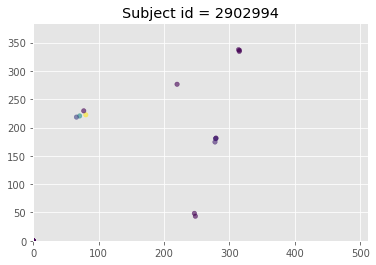

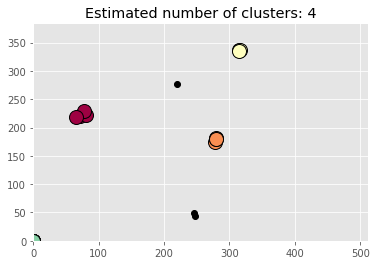

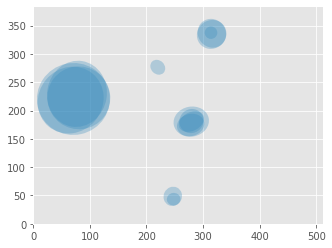

06240907_proc_00395.png


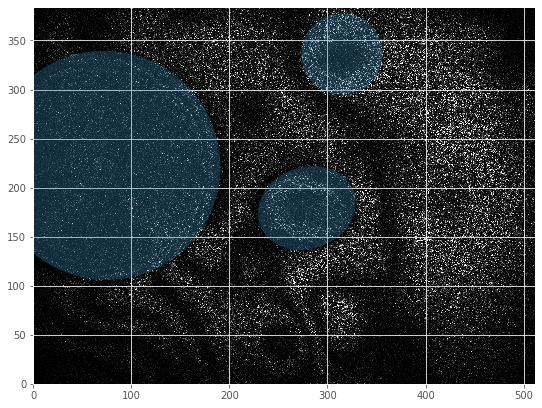

In [10]:
df_to_center_plt(d['coords2902994'])

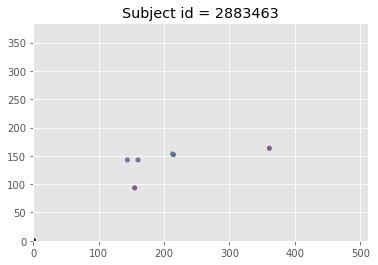

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


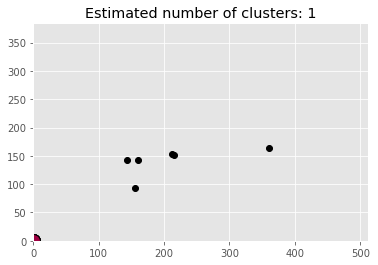

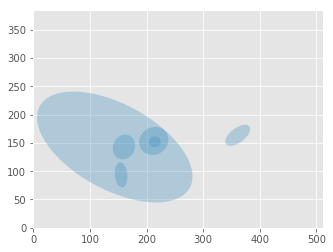

X =  [[       0.        0.  2883463.        0.        0.        0.        0.]
 [       0.        0.  2883463.        0.        0.        0.        0.]
 [       0.        0.  2883463.        0.        0.        0.        0.]
 [       0.        0.  2883463.        0.        0.        0.        0.]
 [       0.        0.  2883463.        0.        0.        0.        0.]
 [       0.        0.  2883463.        0.        0.        0.        0.]
 [       0.        0.  2883463.        0.        0.        0.        0.]]

 len(X) =  7
x_mean =  [0.0]
y_mean =  [0.0]
fringe_count_mean =  [0.0]
rx_mean =  [0.0]
ry_mean =  [0.0]
angle_mean =  [0.0]
06241902_proc_00464.png


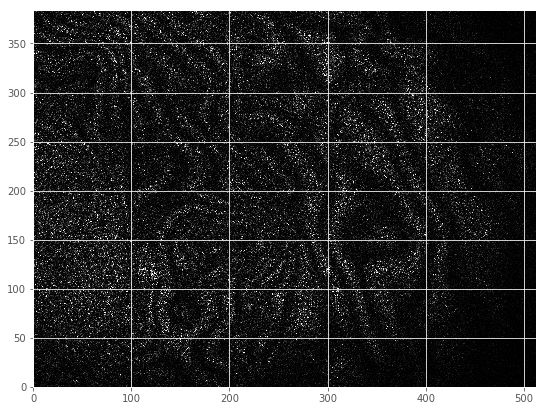

averages =  [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]
1

 average_list =  [[0.0, 0.0, '2883463', 0.0, 0.0, 0.0, 0.0]]

 keepgood =  [[0, 0, '2883463', 0, 0, 0, 0], [0, 0, '2883463', 0, 0, 0, 0], [0, 0, '2883463', 0, 0, 0, 0], [0, 0, '2883463', 0, 0, 0, 0], [0, 0, '2883463', 0, 0, 0, 0], [0, 0, '2883463', 0, 0, 0, 0], [0, 0, '2883463', 0, 0, 0, 0]]


In [307]:
df_to_center_plt(d['coords2883463'])

## Write a loop to iterate over all subject sets in the dictionary:
(Try to clear output after running before commit to git repo.)

In [ ]:
for key, value in d.items():
    #print(len(value))
    if len(value)  >0 and value[0][0] != 'None':
#    if len(value)  >0 and None not in value[key]:
        print("key =",key,"value = ", value,"\n")
    #if len(d.items()) > 0:
#        df_to_center_plt("{}".format(key))
        df_to_center_plt(value)
 
    #df_to_center_plt(key)

## For testing purposes - may delete later:

In [12]:
if len(parsed_json)==2:
    for i in range(len(parsed_json[1]['value'])):
        print(parsed_json[1]['value'][i]['x'])
        
elif len(parsed_json)==1:
    print("No antinodes found!")

No antinodes found!


In [13]:
print(parsed_json[1]['value'][0]['angle'])

IndexError: list index out of range

In [200]:
d.items()

dict_items([('coords2883584', [[397.296875, 157, '2883584', 10, 63.071388124885914, 41.19465984809196, 5.572197803963803], [212.796875, 143.75, '2883584', 4, 65.7419196555744, 61.587336360651285, 32.399840173919344], [209, 144.760009765625, '2883584', 1, 85.44003745317531, 42.720018726587654, -20.556045219583467], [23, 343.760009765625, '2883584', 1, 54.405882034941776, 27.202941017470888, 17.102728969052375], [203.796875, 139.75, '2883584', 7, 98.68130522039117, 49.34065261019558, 19.53665493812839], [214.6999969482422, 142.86666870117188, '2883584', 4, 55.036351623268054, 27.518175811634027, 65.2975697722287], [210.04782104492188, 138.72998046875, '2883584', 6, 74.6911181133972, 65.24596009347535, 26.02959443158207]]), ('coords2883589', [[213.5, 141.46665954589844, '2883589', 3, 64.20280367709809, 63.655321851358195, -46.27303002005671], [208.5, 296.4666748046875, '2883589', 1, 40.80441152620633, 35.510561809129406, -57.65255650055797], [213, 137.46665954589844, '2883589', 5, 66.2419

In [ ]:
i=len(data)
test_parsed_json = json.loads(data[i-2][11])
print(data[i-2][11],"\n")
print(test_parsed_json,"\n")
print(test_parsed_json[1]['value'][0]['angle'],"\n")
print(test_parsed_json[1]['value'],"\n")
print(test_parsed_json[1]['value'][0]['details'][0]['value'],"\n")
for j in range(len(test_parsed_json[1]['value'])):
    print("Fringe count = ",test_parsed_json[1]['value'][j]['details'][0]['value'],"\n")


In [ ]:
subject_id = data[i][13]
print(data[i][13])
print(subject_id)

In [9]:
import itertools
a = [1, 2, 3, 4, 5, 6]
result = itertools.filterfalse(lambda x : x == 3, a) # Output: 
for each in result:
    print(each)

1
2
4
5
6


## Debugging - may remove when done:

In [15]:
ell

NameError: name 'ell' is not defined

In [129]:
allsubjectids = []
for i in range(len(data)):
    allsubjectids.append(int(data[i][13]))
uniquesubjectids = (set(allsubjectids))
len(uniquesubjectids)

493

In [ ]:
for i in range(len(data)):
    #parsed_json = json.loads(data[i][13])
    #print(parsed_json)
    print(data[i][13])

In [40]:
with open("all-good-ellipses.csv") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    keepgood = [r for r in reader]
    


array(['209', '144.760009765625', '2883584', '1', '85.44003745317531',
       '42.720018726587654', '-20.556045219583467'], 
      dtype='<U19')

In [72]:
print(keepgood[1216])
print(results[1215])
print(len(keepgood))
print(len(results))

['205.5', '145.75', '2884169', '10', '78.29431652425353', '75.15317691222374', '-25.20112364547508']
[205.5, 145.75, 2884169, 10, 78.29431652425353, 75.15317691222374, -25.20112364547508]
4378
4373


In [77]:
results = []
for i in range(len(keepgood)):
    try:
        results.append([float(keepgood[i][0]),float(keepgood[i][1]),int(keepgood[i][2]),int(keepgood[i][3]),float(keepgood[i][4]),float(keepgood[i][5]),float(keepgood[i][6])])
    except ValueError:
        pass      # or whatever
    
#print(results)

X_avg = np.array(results)
print(X_avg[0])

X_avg = X_avg[:,[0,1]]
print(X_avg[0])

[  2.09000000e+02   1.44760010e+02   2.88358400e+06   1.00000000e+00
   8.54400375e+01   4.27200187e+01  -2.05560452e+01]
[ 209.          144.76000977]


In [98]:
dbscan_average(keepgood)

gooddata =  [[209.0, 144.760009765625, 2883584, 1, 85.44003745317531, 42.720018726587654, -20.556045219583467], [203.796875, 139.75, 2883584, 7, 98.68130522039117, 49.34065261019558, 19.53665493812839], [214.6999969482422, 142.86666870117188, 2883584, 4, 55.036351623268054, 27.518175811634027, 65.2975697722287], [210.04782104492188, 138.72998046875, 2883584, 6, 74.6911181133972, 65.24596009347535, 26.02959443158207], [213.5, 141.46665954589844, 2883589, 3, 64.20280367709809, 63.655321851358195, -46.27303002005671], [208.5, 296.4666748046875, 2883589, 1, 40.80441152620633, 35.510561809129406, -57.65255650055797], [213.0, 137.46665954589844, 2883589, 5, 66.24198064671678, 63.56099432828282, -61.1134182330893], [208.0, 298.4666748046875, 2883589, 2, 45.880278987817846, 37.94733192202055, -18.43494882292201], [215.0, 145.46665954589844, 2883589, 7, 64.4437739428721, 72.069410986909, 60.94539590092285], [211.81961059570312, 140.47303771972656, 2883589, 4, 61.379833355928874, 63.306788841133


 Good? xy =  [[  2.09000000e+02   1.44760010e+02   2.88358400e+06 ...,   8.54400375e+01
    4.27200187e+01  -2.05560452e+01]
 [  2.03796875e+02   1.39750000e+02   2.88358400e+06 ...,   9.86813052e+01
    4.93406526e+01   1.95366549e+01]
 [  2.14699997e+02   1.42866669e+02   2.88358400e+06 ...,   5.50363516e+01
    2.75181758e+01   6.52975698e+01]
 ..., 
 [  2.12162766e+02   1.55158283e+02   2.88358300e+06 ...,   7.57567537e+01
    8.32408626e+01  -7.67014313e+01]
 [  2.16000000e+02   1.51500000e+02   2.88358300e+06 ...,   5.45893763e+01
    6.88839604e+01  -2.84429286e+01]
 [  2.16633331e+02   1.48466675e+02   2.88358300e+06 ...,   7.42495791e+01
    6.88839672e+01  -2.76810586e+01]]

 Good? xy =  [[  2.08500000e+02   2.96466675e+02   2.88358900e+06 ...,   4.08044115e+01
    3.55105618e+01  -5.76525565e+01]
 [  2.08000000e+02   2.98466675e+02   2.88358900e+06 ...,   4.58802790e+01
    3.79473319e+01  -1.84349488e+01]
 [  2.07944504e+02   2.95477783e+02   2.88358900e+06 ...,   2.951201

/Users/amorriso/anaconda/lib/python3.6/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


[array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64),
 array([], shape=(0, 7), dtype=float64)]

In [117]:
ry

NameError: name 'ry' is not defined

In [135]:
from astropy.stats import circmean
from astropy import units as u

test_angles = np.array([5.0,355.0,15.0])*u.deg
test_angles_circmean = circmean(2*test_angles)
print(test_angles_circmean.value/2)

4.9999999999999964


06241902_proc_00585.png
06241902_proc_00585.png
2883584


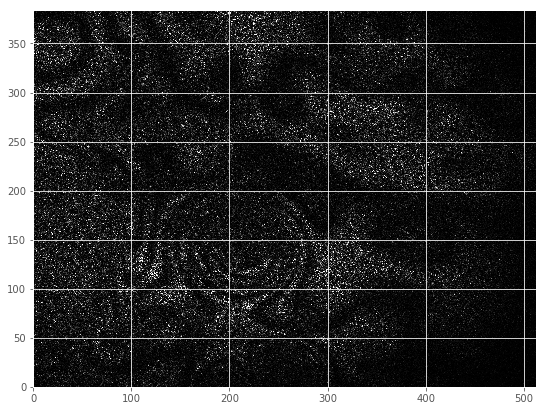

In [291]:
with open("all-subject-ids.csv") as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    subjects = [r for r in reader]

#print(subjects)    
for i in range(len(subjects)):
    if subjects[i][0] == keepgood[0][2]:
        print(subjects[i][1])
        filetoopen = subjects[i][1]

print(filetoopen)        
#subjects.index(keepgood[0][2])
print(keepgood[0][2])    
    
img = plt.imread("./images/"+filetoopen)
fig, ax_new = plt.subplots(figsize=(9, 8), dpi= 72, facecolor='w', edgecolor='k')
ax_new.imshow(img,origin='lower',extent=[0, 512, 0, 384],cmap='gray')
plt.show()

In [257]:
keepgood

[['209',
  '144.760009765625',
  '2883584',
  '1',
  '85.44003745317531',
  '42.720018726587654',
  '-20.556045219583467'],
 ['203.796875',
  '139.75',
  '2883584',
  '7',
  '98.68130522039117',
  '49.34065261019558',
  '19.53665493812839'],
 ['214.6999969482422',
  '142.86666870117188',
  '2883584',
  '4',
  '55.036351623268054',
  '27.518175811634027',
  '65.2975697722287'],
 ['210.04782104492188',
  '138.72998046875',
  '2883584',
  '6',
  '74.6911181133972',
  '65.24596009347535',
  '26.02959443158207'],
 ['213.5',
  '141.46665954589844',
  '2883589',
  '3',
  '64.20280367709809',
  '63.655321851358195',
  '-46.27303002005671'],
 ['208.5',
  '296.4666748046875',
  '2883589',
  '1',
  '40.80441152620633',
  '35.510561809129406',
  '-57.65255650055797'],
 ['213',
  '137.46665954589844',
  '2883589',
  '5',
  '66.24198064671678',
  '63.56099432828282',
  '-61.1134182330893'],
 ['208',
  '298.4666748046875',
  '2883589',
  '2',
  '45.880278987817846',
  '37.94733192202055',
  '-18.4349